Importa as bibliotecas necessárias para o pré-processamento do Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

Carrega o Dataset bruto

In [207]:
df_prop = pd.read_excel('dataset_full_feats.xlsx')

Visualiza informações básicas do conteúdo do Dataset

In [163]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46319 entries, 0 to 46318
Data columns (total 11 columns):
COD_PROP    46319 non-null int64
ANO         46319 non-null int64
NUM_PROP    46319 non-null int64
NOM_PROP    46319 non-null object
TEMAS       46319 non-null object
POLITICO    33402 non-null object
SEXO        33402 non-null object
PARTIDO     33333 non-null object
UF          33380 non-null object
REGIAO      33380 non-null object
TEXTO       46319 non-null object
dtypes: int64(3), object(8)
memory usage: 3.9+ MB


In [205]:
df_prop.head(3)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO
0,133436,2003,1989,PL 1989/2003,INDUSTRIA,RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...
1,132228,2003,1923,PL 1923/2003,ARTE E CULTURA,BETO ALBUQUERQUE,M,PSB,RIO GRANDE DO SUL,SUL,Confere ao município de Passo Fundo o título d...
2,118055,2003,1165,PL 1165/2003,ARTE E CULTURA,ELIMAR MÁXIMO DAMASCENO,M,PRONA,SÃO PAULO,SUDESTE,Inscreve o nome de Heitor Villa-Lobos no Livro...


Identifica a quantidade total de temas presentes no Dataset

In [206]:
df_prop['TEMAS'].nunique()

45

Elimina o texto "(UTILIZADO ATE A LEGISLATURA 53)" existente em alguns nomes de temas para melhorar visualização e operação com os temas.

In [165]:
for index, tema in df_prop.iterrows():
    legis_53 = '(UTILIZADO ATE A LEGISLATURA 53)'
    if legis_53 in tema['TEMAS']:
        tema_processado = tema['TEMAS'].replace(legis_53, '')
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_processado

In [154]:
df_prop.head(4)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO
0,133436,2003,1989,PL 1989/2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR",RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...
1,132228,2003,1923,PL 1923/2003,ARTE E CULTURA,BETO ALBUQUERQUE,M,PSB,RIO GRANDE DO SUL,SUL,Confere ao município de Passo Fundo o título d...
2,118055,2003,1165,PL 1165/2003,ARTE E CULTURA,ELIMAR MÁXIMO DAMASCENO,M,PRONA,SÃO PAULO,SUDESTE,Inscreve o nome de Heitor Villa-Lobos no Livro...
3,132141,2003,1917,PL 1917/2003,TRIBUTACAO,CARLOS NADER,M,PFL,RIO DE JANEIRO,SUDESTE,Dispõe sobre a isenção do Imposto sobre Produt...
4,253807,2004,3574,PL 3574/2004,SEGURANCA PUBLICA,CARLOS NADER,M,PFL,RIO DE JANEIRO,SUDESTE,"""Autoriza o uso, pelas Polícias Civil e Milita..."


Mostra a quantidade de entradas para cada um dos temas existentes

In [167]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                                                                8466
TRABALHO E EMPREGO                                                                          2455
ADMINISTRACAO PUBLICA                                                                       2356
EDUCACAO                                                                                    2073
TRIBUTACAO                                                                                  2056
DIREITO PENAL E PROCESSUAL PENAL                                                            1788
SAUDE                                                                                       1539
DIREITOS HUMANOS, MINORIAS E CIDADANIA                                                      1439
VIACAO E TRANSPORTES                                                                        1359
HOMENAGENS E DATAS COMEMORATIVAS                                                            1219
DIREITO CIVIL E PROCESSUAL CIV

In [180]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO ADMINISTRATIVA DO ESTADO'
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [132]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO '
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

Identificado diversos temas que possuem subtemas e portanto estão sendo identificados pelo código como categorias distintas. 
Para resolver isso o código abaixo agrega todos os temas que possuem subtemas em seu tema primário, salvo algumas exceções.

In [201]:
excecoes = ['RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA', 
            'DIREITOS HUMANOS, MINORIAS E CIDADANIA', 
            'ORGANIZACAO POLITICA, PARTIDARIA E ELEITORAL',
            'ECONOMIA, ADMINISTRACAO FINANCEIRA E ORCAMENTARIA',
            'INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR',
            'AGRICULTURA, PECUARIA E PESCA']
for index, tema in df_prop.iterrows():
    virgula = ','
    if virgula in tema['TEMAS']:
        if not tema['TEMAS'] in excecoes: 
            tema_principal = tema['TEMAS'].split(',')[0]
            df_prop.at[df_prop.index[index], 'TEMAS'] = tema_principal

In [202]:
df_prop['TEMAS'].nunique()

45

In [203]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                                                      8854
ADMINISTRACAO PUBLICA                                                             3565
TRABALHO E EMPREGO                                                                2591
EDUCACAO                                                                          2510
DIREITO PENAL E PROCESSUAL PENAL                                                  2318
TRIBUTACAO                                                                        2136
INDUSTRIA                                                                         1859
SAUDE                                                                             1799
DIREITO CIVIL E PROCESSUAL CIVIL                                                  1536
DESENVOLVIMENTO URBANO E TRANSITO                                                 1465
DIREITOS HUMANOS, MINORIAS E CIDADANIA                                            1439
VIACAO E TRANSPORTES                       

In [39]:
df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

In [40]:
df_prop.sort_values(by='TEMAS', ascending=True, inplace=True)

In [142]:
df_prop.describe()

,COD_PROP,ANO,NUM_PROP
count,3.897100e+04,38971.000000,38971.000000
mean,5.374733e+05,2008.586821,2984.650509
std,4.924348e+05,4.355916,2381.870490
min,4.332100e+04,2002.000000,1.000000
25%,2.744510e+05,2004.000000,852.000000
50%,4.241960e+05,2009.000000,2436.000000
75%,5.575565e+05,2012.000000,4871.000000
max,2.089842e+06,2016.000000,8334.000000


In [143]:
df_prop.count()

COD_PROP    38971
ANO         38971
NUM_PROP    38971
NOM_PROP    38971
TEMAS       38971
POLITICO    27309
SEXO        27309
PARTIDO     27251
UF          27295
REGIAO      27295
TEXTO       38971
dtype: int64

Visualiza a distribuição das entradas entre os TEMAS

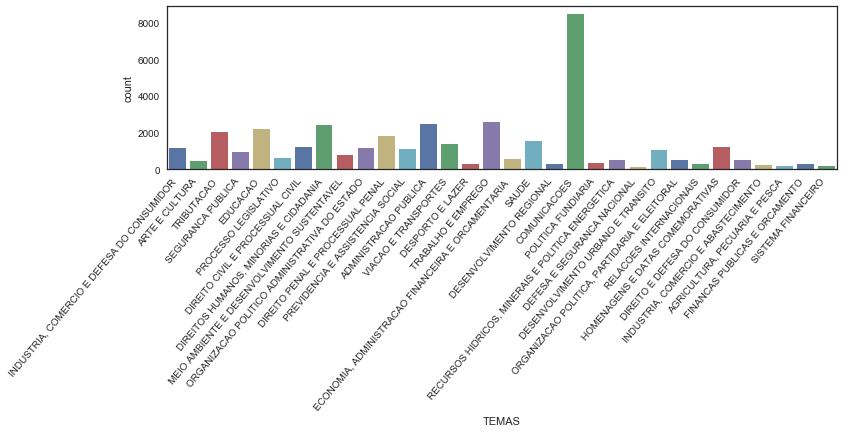

In [144]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_prop['TEMAS'], data=df_prop, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

Verifica distribuição das entradas

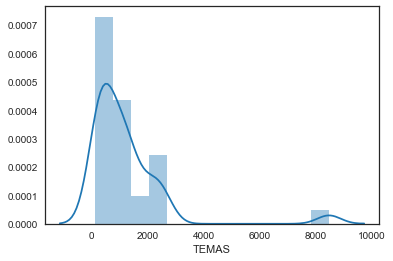

In [145]:
sns.distplot(df_prop['TEMAS'].value_counts())

Verifica se há alguma correlação entre ANO e TEMAS

In [45]:
corr_df_prop = df_prop.copy()
corr_df_prop['ALVO'] = df_prop['TEMAS']
corr_df_prop.ALVO = pd.Categorical(corr_df_prop.ALVO)
corr_df_prop['ALVO'] = corr_df_prop.ALVO.cat.codes
corr_df_prop.corr()

,ANO,ALVO
ANO,1.000000,0.062668
ALVO,0.062668,1.000000


In [146]:
df_prop['TEXTO'].nunique()

37378

In [47]:
d_count = 0
d_list = df_prop['TEXTO'].duplicated()
d_list.dtype

dtype('bool')

Carrega arquivo do dataset que teve o texto já processado e tokenizado para análise

In [48]:
df_tokenized = pd.read_excel('Processed_File.xlsx')

In [49]:
df_tokenized['TOKENIZED'].describe()

count                              30505
unique                             26399
top        dá nov red art constitu feder
freq                                  91
Name: TOKENIZED, dtype: object

In [50]:
df_tokenized['TEMAS'].value_counts(normalize=True) * 100

TRABALHO E EMPREGO                                    8.441239
ADMINISTRACAO PUBLICA                                 8.060974
DIREITOS HUMANOS, MINORIAS E CIDADANIA                7.995411
EDUCACAO                                              7.139813
TRIBUTACAO                                            6.739879
DIREITO PENAL E PROCESSUAL PENAL                      5.861334
SAUDE                                                 5.045075
VIACAO E TRANSPORTES                                  4.455007
HOMENAGENS E DATAS COMEMORATIVAS                      3.996066
DIREITO CIVIL E PROCESSUAL CIVIL                      3.992788
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            3.878053
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         3.828881
PREVIDENCIA E ASSISTENCIA SOCIAL                      3.687920
DESENVOLVIMENTO URBANO E TRANSITO                     3.451893
SEGURANCA PUBLICA                                     3.147025
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL           2

Pegas os indices de todas as entradas que estão duplicadas no dataset

In [51]:
duplicated_entries = []
for idx, v in df_tokenized.duplicated(subset='TOKENIZED', keep='first').iteritems():
    if v is True:
        duplicated_entries.append(idx)

Remove os itens duplicados do dataset

In [52]:
for idx, values in df_tokenized.iterrows():
    if idx in duplicated_entries:
        df_tokenized.drop(labels=idx, axis=0, inplace=True)

In [53]:
df_tokenized['TOKENIZED'].describe()

count                                                 26399
unique                                                26399
top        alt lei nº julh reduz alíquot contribu cofim ...
freq                                                      1
Name: TOKENIZED, dtype: object

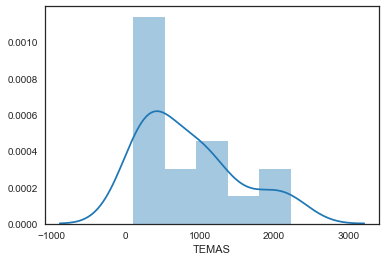

In [54]:
sns.distplot(df_tokenized['TEMAS'].value_counts())

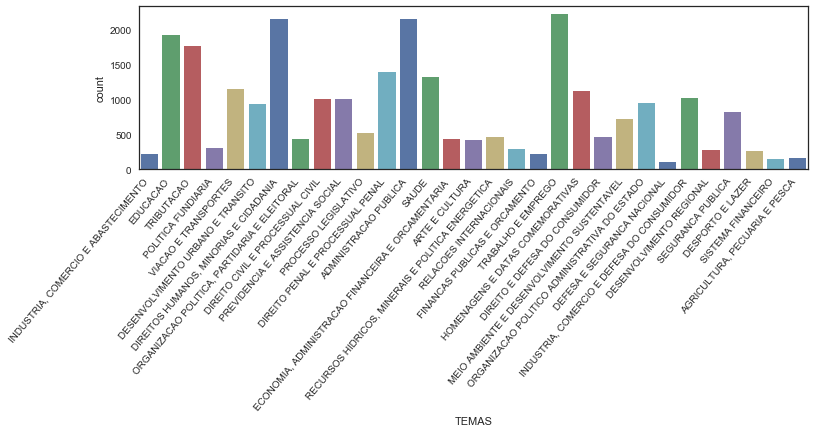

In [55]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_tokenized['TEMAS'], data=df_tokenized, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

Distribuição em % dos TEMAS após limpeza de entradas duplicadas
Resultado: Ainda há uma discrepância grande entre representatividade das classes

In [56]:
df_tokenized['TEMAS'].value_counts(normalize=True) * 100

TRABALHO E EMPREGO                                    8.435926
DIREITOS HUMANOS, MINORIAS E CIDADANIA                8.148036
ADMINISTRACAO PUBLICA                                 8.136672
EDUCACAO                                              7.295731
TRIBUTACAO                                            6.697223
DIREITO PENAL E PROCESSUAL PENAL                      5.288079
SAUDE                                                 5.007765
VIACAO E TRANSPORTES                                  4.363802
HOMENAGENS E DATAS COMEMORATIVAS                      4.227433
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            3.867571
DIREITO CIVIL E PROCESSUAL CIVIL                      3.837267
PREVIDENCIA E ASSISTENCIA SOCIAL                      3.822114
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         3.575893
DESENVOLVIMENTO URBANO E TRANSITO                     3.545589
SEGURANCA PUBLICA                                     3.121330
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL           2

**A seguir será analisado a correlação de outras variáveis com os TEMAS:**

Correlação de variáveis adicionais com TEMAS:

Carrega o dataset com oas novas variáveis

In [147]:
#dataset_full = pd.read_excel('dataset_full_feats.xlsx')
dataset_full = df_prop

Transformando as variáveis categóricas textuais em códigos para que possa ser calculado a correlação entre elas

In [148]:
corr_df_prop = dataset_full.copy()
#Categorização e correlação de SEXO
corr_df_prop['CAT_SEXO'] = dataset_full['SEXO']
corr_df_prop.CAT_SEXO = pd.Categorical(corr_df_prop.CAT_SEXO)
corr_df_prop['CAT_SEXO'] = corr_df_prop.CAT_SEXO.cat.codes
#Categorização e correlação de TEMAS
corr_df_prop['CAT_TEMAS'] = dataset_full['TEMAS']
corr_df_prop.CAT_TEMAS = pd.Categorical(corr_df_prop.CAT_TEMAS)
corr_df_prop['CAT_TEMAS'] = corr_df_prop.CAT_TEMAS.cat.codes
#Categorização e correlação de POLITICO
corr_df_prop['CAT_POLITICO'] = dataset_full['POLITICO']
corr_df_prop.CAT_POLITICO = pd.Categorical(corr_df_prop.CAT_POLITICO)
corr_df_prop['CAT_POLITICO'] = corr_df_prop.CAT_POLITICO.cat.codes
#Categorização e correlação de PARTIDO
corr_df_prop['CAT_PARTIDO'] = dataset_full['PARTIDO']
corr_df_prop.CAT_PARTIDO = pd.Categorical(corr_df_prop.CAT_PARTIDO)
corr_df_prop['CAT_PARTIDO'] = corr_df_prop.CAT_PARTIDO.cat.codes
#Categorização e correlação de UF
corr_df_prop['CAT_UF'] = dataset_full['UF']
corr_df_prop.CAT_UF = pd.Categorical(corr_df_prop.CAT_UF)
corr_df_prop['CAT_UF'] = corr_df_prop.CAT_UF.cat.codes
#Categorização e correlação de REGIAO
corr_df_prop['CAT_REGIAO'] = dataset_full['REGIAO']
corr_df_prop.CAT_REGIAO = pd.Categorical(corr_df_prop.CAT_REGIAO)
corr_df_prop['CAT_REGIAO'] = corr_df_prop.CAT_REGIAO.cat.codes
#Exibe a correlação:
corr_df_prop.corr()

,COD_PROP,ANO,NUM_PROP,CAT_SEXO,CAT_TEMAS,CAT_POLITICO,CAT_PARTIDO,CAT_UF,CAT_REGIAO
COD_PROP,1.000000,0.801977,0.022986,0.172448,0.052901,0.126282,0.165282,0.116825,0.126195
ANO,0.801977,1.000000,0.059005,0.171953,0.062668,0.143083,0.182750,0.128089,0.117589
NUM_PROP,0.022986,0.059005,1.000000,0.201741,0.160926,0.127932,0.129068,0.201392,0.202740
CAT_SEXO,0.172448,0.171953,0.201741,1.000000,0.433122,0.643686,0.661420,0.756954,0.783789
CAT_TEMAS,0.052901,0.062668,0.160926,0.433122,1.000000,0.291260,0.292217,0.359531,0.376998
CAT_POLITICO,0.126282,0.143083,0.127932,0.643686,0.291260,1.000000,0.479581,0.528553,0.534414
CAT_PARTIDO,0.165282,0.182750,0.129068,0.661420,0.292217,0.479581,1.000000,0.577319,0.574543
CAT_UF,0.116825,0.128089,0.201392,0.756954,0.359531,0.528553,0.577319,1.000000,0.830755
CAT_REGIAO,0.126195,0.117589,0.202740,0.783789,0.376998,0.534414,0.574543,0.830755,1.000000


Abaixo o Heatmap das correlações entre as variáveis. No que diz respeito aos temas, as características com maior correlação são SEXO, UF e REGIAO com valores dentro entre 0.3 e 0.4, seguido pelo POLITICO e PARTIDO, ambos com 0.25. 

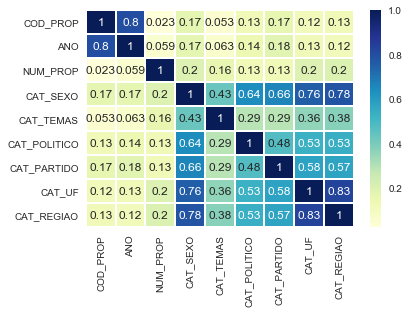

In [149]:
sns.heatmap(corr_df_prop.corr(), cmap='YlGnBu',linecolor='white',linewidths=1, annot=True)

In [208]:
corr_df_prop.head(5)

,COD_PROP,ANO,NUM_PROP,NOM_PROP,TEMAS,POLITICO,SEXO,PARTIDO,UF,REGIAO,TEXTO,CAT_SEXO,CAT_TEMAS,CAT_POLITICO,CAT_PARTIDO,CAT_UF,CAT_REGIAO
0,133436,2003,1989,PL 1989/2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR",RONALDO VASCONCELLOS,M,PTB,MINAS GERAIS,SUDESTE,Dispõe sobre o prazo para devolução de encomen...,1,17,1183,30,12,3
1,132228,2003,1923,PL 1923/2003,ARTE E CULTURA,BETO ALBUQUERQUE,M,PSB,RIO GRANDE DO SUL,SUL,Confere ao município de Passo Fundo o título d...,1,2,167,21,20,4
2,118055,2003,1165,PL 1165/2003,ARTE E CULTURA,ELIMAR MÁXIMO DAMASCENO,M,PRONA,SÃO PAULO,SUDESTE,Inscreve o nome de Heitor Villa-Lobos no Livro...,1,2,394,17,25,3
3,132141,2003,1917,PL 1917/2003,TRIBUTACAO,CARLOS NADER,M,PFL,RIO DE JANEIRO,SUDESTE,Dispõe sobre a isenção do Imposto sobre Produt...,1,30,218,5,18,3
4,253807,2004,3574,PL 3574/2004,SEGURANCA PUBLICA,CARLOS NADER,M,PFL,RIO DE JANEIRO,SUDESTE,"""Autoriza o uso, pelas Polícias Civil e Milita...",1,27,218,5,18,3
